In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy # to split categorical data up
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.formula.api import mnlogit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from IPython.display import display, HTML # used to print out pretty pandas dataframes
import yaml
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy.stats as stats # fit curve to distributions

import matplotlib.pyplot as plt

%matplotlib inline

from __future__ import print_function

# Load data from CSV and Header

The data is processed in load-data.ipynb. This results in a set of CSV files which are loaded here.

In [2]:
df = pd.read_csv('gosiss/gossis-data.csv')
print('done')

c:\python27\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,6,8,10,11,17,19,20,21,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done


In [3]:
hdr = pd.read_csv('gosiss/hdr/header.csv',header=None,sep=',')[0].values

# load yaml definitions
with open("gosiss/hdr/variable-definitions.yaml", 'r') as stream:
    try:
        varlist = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# convert to dataframe
df_var = pd.DataFrame.from_dict(varlist, orient='index')
df_var['varname'] = df_var.index

# specify the order of the categories - data is output in this order
category_order = {'identifier': 1,
                  'demographic': 2,
                  'APACHE covariate': 3,
                  'vitals': 4,
                  'labs': 5,
                  'labs blood gas': 6,
                  'APACHE prediction': 10}
df_var['category_order'] = df_var['category'].map(category_order)

# sort df by the category, then by the variable name
df_var.sort_values(['category_order','varname'],inplace=True)


# Completely missing table

In [4]:
# % missing for each var
missingness = 100.0 * (df.isnull()).sum(axis=0) / df['icu_id'].count()
dic={}
header=['anzics','eicu', 'mimic','orchestra']
for var in df_var['varname']:
    if var in ['hospital_bed_size_numeric', 'icu_admit_type']:
        continue
    miss=[]
    for db in header:
        miss=miss+[(df.loc[df['data_source']==db,var].dropna().count()==0).sum()]
    dic[var]=miss

missing = pd.DataFrame(dic, index=header)
display(HTML(missing.transpose().to_html()))

,anzics,eicu,mimic,orchestra
age,0,0,0,0
albumin_apache,0,0,0,1
apache_3j_hospital_death_prob,0,1,1,1
apache_3j_score,0,0,1,1
apache_4a_hospital_death_prob,1,0,1,1
apache_4a_icu_death_prob,1,0,1,1
apsiii,0,0,0,1
arf_apache,0,0,1,1
bilirubin_apache,0,0,0,1
bmi,0,0,0,0


In [16]:
missing.transpose().to_csv('missing.csv',index=True)

In [17]:
df.shape

(490280, 201)

In [5]:
apache=['hospital_death','albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache']
aem= ['hospital_death','age', 'bmi', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'd1_wbc_max', 'd1_wbc_min', 'elective_surgery', 'gender', 'height', 'pre_icu_los_days', 'weight']
orchestra=['hospital_death','age', 'bmi', 'elective_surgery', 'gender', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_bilirubin_max', 'h1_creatinine_max', 'h1_diasbp_min', 'h1_heartrate_max', 'h1_lactate_max', 'h1_mbp_min', 'h1_pao2fio2ratio_min', 'h1_platelets_min', 'h1_resprate_max', 'h1_sysbp_min', 'h1_temp_max', 'h1_wbc_max', 'height', 'pre_icu_los_days', 'weight']


In [157]:
def counting(c):
    a = df.loc[(df['data_source']=='anzics'),c].dropna().count()
    e = df.loc[(df['data_source']=='eicu'),c].dropna().count()
    m = df.loc[(df['data_source']=='mimic'),c].dropna().count()
    o = df.loc[(df['data_source']=='orchestra'),c].dropna().count()
    return [a,e,m,o]

totals=[float(i) for i in counting('data_source')]
comp_dict={}

covariates = orchestra
for column in covariates:
    if column in ['data_source','hospital_bed_size_numeric','icu_admit_type']:
        continue           
    comp_dict[column]=np.round_(np.divide(counting(column),totals)*100, decimals=2)
tb = pd.DataFrame(comp_dict, index=header)
tb = tb.replace(to_replace=float(0), value='')
tb=tb.transpose()
tb.round(2).style
display(HTML(tb.to_html()))
tb.to_csv('miss.csv',index=True)

,anzics,eicu,mimic,orchestra
age,100,96.46,100,100
bmi,31.32,96.71,41.58,58.06
elective_surgery,99.84,100,100,100
gender,99.99,99.97,100,99.98
h1_arterial_pco2_max,,17.52,31.5,37.41
h1_arterial_pco2_min,,17.52,31.5,11.63
h1_arterial_ph_max,,17.16,31.5,37.56
h1_arterial_ph_min,,17.16,31.5,11.75
h1_arterial_po2_max,,17.53,31.5,37.43
h1_arterial_po2_min,,17.53,31.5,11.61


# Databases of interest with their common variables

In [35]:
db_train=1   #eicu
db_test=0    #ANZICS
var_interest=[]

for m in missing:
    variable=missing[m]
    if (int(variable[1])+int(variable[2])+int(variable[0])==0)&(df_var[df_var['varname']==m]['category']!='identifier').tolist()[0]:
        var_interest=var_interest+[m]
print(' + '.join(var_interest))

age + albumin_apache + apsiii + bilirubin_apache + bmi + bun_apache + country + creatinine_apache + d1_creatinine_max + d1_creatinine_min + d1_diasbp_max + d1_diasbp_min + d1_glucose_max + d1_glucose_min + d1_hco3_max + d1_hco3_min + d1_heartrate_max + d1_heartrate_min + d1_hemaglobin_max + d1_hemaglobin_min + d1_hematocrit_max + d1_hematocrit_min + d1_mbp_max + d1_mbp_min + d1_platelets_max + d1_platelets_min + d1_potassium_max + d1_potassium_min + d1_resprate_max + d1_resprate_min + d1_sodium_max + d1_sodium_min + d1_sysbp_max + d1_sysbp_min + d1_temp_max + d1_temp_min + d1_wbc_max + d1_wbc_min + elective_surgery + ethnicity + fio2_apache + gcs_eyes_apache + gcs_motor_apache + gcs_verbal_apache + gender + glucose_apache + heart_rate_apache + height + hematocrit_apache + hospital_admit_source + hospital_death + hospital_disch_location + hospital_los_days + icu_death + icu_id + icu_los_days + icu_stay_type + map_apache + paco2_apache + paco2_for_ph_apache + pao2_apache + ph_apache + pr

for orchestra vs eicu and mimic (25)

age + bmi + elective_surgery + gender + h1_arterial_pco2_max + h1_arterial_pco2_min + h1_arterial_ph_max + h1_arterial_ph_min + h1_arterial_po2_max + h1_arterial_po2_min + h1_bilirubin_max + h1_creatinine_max + h1_diasbp_min + h1_heartrate_max + h1_lactate_max + h1_mbp_min + h1_pao2fio2ratio_min + h1_platelets_min + h1_resprate_max + h1_sysbp_min + h1_temp_max + h1_wbc_max + height + pre_icu_los_days + weight

In [45]:
print(' + '.join([x for x in var_interest if '_apache' in x]))

albumin_apache + bilirubin_apache + bun_apache + creatinine_apache + fio2_apache + gcs_eyes_apache + gcs_motor_apache + gcs_verbal_apache + glucose_apache + heart_rate_apache + hematocrit_apache + map_apache + paco2_apache + paco2_for_ph_apache + pao2_apache + ph_apache + resprate_apache + sodium_apache + temp_apache + urineoutput_apache + ventilated_apache + wbc_apache


with apache (22)

albumin_apache + bilirubin_apache + bun_apache + creatinine_apache + fio2_apache + gcs_eyes_apache + gcs_motor_apache + gcs_verbal_apache + glucose_apache + heart_rate_apache + hematocrit_apache + map_apache + paco2_apache + paco2_for_ph_apache + pao2_apache + ph_apache + resprate_apache + sodium_apache + temp_apache + urineoutput_apache + ventilated_apache + wbc_apache

without apache (37)

age + bmi + d1_creatinine_max + d1_creatinine_min + d1_diasbp_max + d1_diasbp_min + d1_glucose_max + d1_glucose_min + d1_hco3_max + d1_hco3_min + d1_heartrate_max + d1_heartrate_min + d1_hemaglobin_max + d1_hemaglobin_min + d1_hematocrit_max + d1_hematocrit_min + d1_mbp_max + d1_mbp_min + d1_platelets_max + d1_platelets_min + d1_potassium_max + d1_potassium_min + d1_resprate_max + d1_resprate_min + d1_sodium_max + d1_sodium_min + d1_sysbp_max + d1_sysbp_min + d1_temp_max + d1_temp_min + d1_wbc_max + d1_wbc_min + elective_surgery + gender + height + pre_icu_los_days + weight

In [19]:
df=df.dropna(axis=0, subset=['hospital_death'])
df.loc[(df['glucose_apache']>2000),'glucose_apache']=float('nan')
#orchestra = blue
#mimic = red
#anzics = green
#eicu = purple
color_dic = {'orchestra': 'blue', 'mimic': 'red', 'anzics': 'green', 'eicu': 'purple'}
train_name='mimic'
train_inc=df[apache][df['data_source']==train_name]
print(train_inc.shape)

name_1='anzics'
name_2='eicu'
test_inc_1=df[apache][df['data_source']==name_1]
print(test_inc_1.shape)
test_inc_2=df[apache][df['data_source']==name_2]
print(test_inc_2.shape)

(38139, 23)
(265807, 23)
(122893, 23)


# Handle missing data

In [7]:
def impute(dataset):
    for column in dataset:
        if column=='hospital_death':
            continue
        datatype=df_var[df_var['varname']==column]['dataType'].tolist()[0]
        dataset[column+'_missing'] = dataset[column].isnull()
        if (column == 'bmi') or (datatype=='numeric') :
            fillin=np.mean(dataset[column].dropna().values)
        else:
            fillin=dataset[column].value_counts().idxmax()
        dataset[column].fillna(value=fillin, inplace=True)  
    return dataset

In [20]:
train=impute(train_inc)
test_1=impute(test_inc_1)
test_2=impute(test_inc_2)

print(train.shape)

(38139, 45)


In [112]:
print(train['d1_sysbp_max_missing'].value_counts())
print(train['d1_diasbp_max_missing'].value_counts())

False    38027
True       112
Name: d1_sysbp_max_missing, dtype: int64
False    38026
True       113
Name: d1_diasbp_max_missing, dtype: int64


In [21]:
x=train.corr()
dic={}
remove=[]

for column in train:
    if 'missing' in column:
        truecount=train[column].sum()
        if (truecount in dic.keys()) or (truecount==0) or (truecount == train.shape[0]):
            remove=remove+[column]
        else:
            dic[truecount]=1

train=train.drop(remove, axis=1)
test_1=test_1.drop(remove,axis=1)
test_2=test_2.drop(remove,axis=1)
print(train.shape)
print(test_1.shape)
print(test_2.shape)
print(remove)

x=train.corr()
for i in x:
    for j in x:
        if (x[i][j]==1) & (i!=j):
            print((i,j))


(38139, 41)
(265807, 41)
(122893, 41)
['paco2_for_ph_apache_missing', 'pao2_apache_missing', 'ph_apache_missing', 'ventilated_apache_missing']


In [16]:
# APACHE dropped ['paco2_for_ph_apache'] with train = eicu
# AEM dropped ['d1_diasbp_max_missing','d1_glucose_max_missing'] with train = mimic
# EMO dropped ['h1_diasbp_min_missing'] with train = eicu
train=train.drop('paco2_for_ph_apache',axis=1)
test_1=test_1.drop('paco2_for_ph_apache',axis=1)
test_2=test_2.drop('paco2_for_ph_apache',axis=1)


# AUROC

In [117]:
idxKeep = (~df['hospital_death'].isnull()) & (~df['apache_3j_score'].isnull())
auc = roc_auc_score( df.loc[idxKeep, 'hospital_death'], df.loc[idxKeep, 'apache_3j_score'] )
print(auc)

0.822468705745


In [22]:
print(' + '.join(list(train)))

hospital_death + albumin_apache + arf_apache + bilirubin_apache + bun_apache + creatinine_apache + fio2_apache + gcs_eyes_apache + gcs_motor_apache + gcs_verbal_apache + glucose_apache + heart_rate_apache + hematocrit_apache + map_apache + paco2_apache + pao2_apache + ph_apache + resprate_apache + sodium_apache + temp_apache + urineoutput_apache + ventilated_apache + wbc_apache + albumin_apache_missing + bilirubin_apache_missing + bun_apache_missing + creatinine_apache_missing + fio2_apache_missing + gcs_eyes_apache_missing + glucose_apache_missing + hematocrit_apache_missing + sodium_apache_missing + temp_apache_missing + urineoutput_apache_missing + wbc_apache_missing


# Predictive model

In [22]:
f = 'hospital_death ~ ' + ' + '.join([x for x in train.columns if x != 'hospital_death'])
y,data = patsy.dmatrices(f, data=train, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')

print('')
# logistic on hospital mortality
model = sm.Logit( y , data)
results = model.fit()
print(results.summary())
"""
#coef = 1.0312
#print('Odds ratio of exposure: {:2.2f}').format(np.exp(coef))
for i, col in enumerate(train.columns):
    if col=='hospital_death':
        col_print='Intercept'
    else:
        col_print=col
    print('{:30s}'.format(col_print),end='\t')
    print('{:2.2f}'.format(np.exp(results.params[i])))
"""
print(name_1)
y_test,data_test_1 = patsy.dmatrices(f, data=test_1, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')
pred_1=results.predict(data_test_1)
#auc = roc_auc_score( y,  model.fitted_values )

auc_1 = roc_auc_score(test_1['hospital_death'], pred_1)
print(auc_1)

print(name_2)
y_test,data_test_2 = patsy.dmatrices(f, data=test_2, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')
pred_2=results.predict(data_test_2)
#auc = roc_auc_score( y,  model.fitted_values )
auc_2 = roc_auc_score(test_2['hospital_death'], pred_2)
print(auc_2)


Optimization terminated successfully.
         Current function value: 0.271817
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         hospital_death   No. Observations:                38139
Model:                          Logit   Df Residuals:                    38098
Method:                           MLE   Df Model:                           40
Date:                Thu, 25 May 2017   Pseudo R-squ.:                  0.2163
Time:                        21:41:55   Log-Likelihood:                -10367.
converged:                       True   LL-Null:                       -13228.
                                        LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             11.4961      1.840   

## B-Spline

In [204]:
var_list = list()
#possible list: 'albumin_apache','bun_apache','map_apache','glucose_apache','heart_rate_apache','hematocrit_apache',
#              'pao2_apache','paco2_apache','ph_apache','resprate_apache','sodium_apache','temp_apache'
for x in train.columns:
    if x == 'hospital_death':
        continue
    elif x in ['map_apache','glucose_apache','heart_rate_apache',
              'ph_apache','resprate_apache','temp_apache', 'wbc_apache', 'h1_arterial_po2_min', 'h1_arterial_po2_max']:
        var_list.append('+ bs(' + x + ', df=3, degree=3)')
    else:
        var_list.append('+ ' + x)
        

f = 'hospital_death ~ ' + ' + '.join(var_list)
y,data = patsy.dmatrices(f, data=train, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')

print('')
# logistic on hospital mortality
model = sm.Logit( y , data)
results = model.fit()
print(results.summary())

#coef = 1.0312
#print('Odds ratio of exposure: {:2.2f}').format(np.exp(coef))
"""
for i, col in enumerate(train.columns):
    if col=='hospital_death':
        col_print='Intercept'
    else:
        col_print=col
    print('{:30s}'.format(col_print),end='\t')
    print('{:2.2f}'.format(np.exp(results.params[i])))
"""

print(name_1)
y_test,data_test_1 = patsy.dmatrices(f, data=test_1, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')
pred_1=results.predict(data_test_1)
#auc = roc_auc_score( y,  model.fitted_values )

auc_1 = roc_auc_score(test_1['hospital_death'], pred_1)
print(auc_1)

print(name_2)
y_test,data_test_2 = patsy.dmatrices(f, data=test_2, eval_env=0,
                     NA_action=patsy.NAAction(on_NA='drop', NA_types=['None', 'NaN']),
                     return_type='matrix')
pred_2=results.predict(data_test_2)
#auc = roc_auc_score( y,  model.fitted_values )
auc_2 = roc_auc_score(test_2['hospital_death'], pred_2)
print(auc_2)


Optimization terminated successfully.
         Current function value: 0.262501
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         hospital_death   No. Observations:                38139
Model:                          Logit   Df Residuals:                    38084
Method:                           MLE   Df Model:                           54
Date:                Thu, 25 May 2017   Pseudo R-squ.:                  0.2431
Time:                        17:59:20   Log-Likelihood:                -10012.
converged:                       True   LL-Null:                       -13228.
                                        LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -6.

In [109]:
np.min(train['d1_temp_min'])

15.0

## Calibration

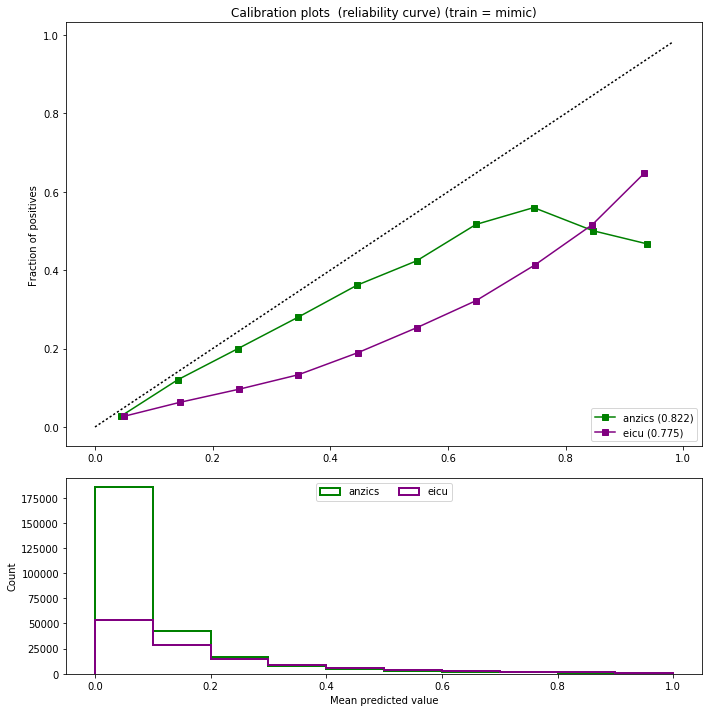

In [23]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

fraction_of_positives_1, mean_predicted_value_1 = calibration_curve(test_1['hospital_death'], pred_1,n_bins=10)
ax1.plot(mean_predicted_value_1, fraction_of_positives_1, "s-",
                 label="%s (%1.3f)" % (name_1, auc_1), color=color_dic[name_1])
ax2.hist(pred_1, range=(0, 1), bins=10, label=name_1,
                 histtype="step", lw=2, color=color_dic[name_1])

fraction_of_positives_2, mean_predicted_value_2 = calibration_curve(test_2['hospital_death'], pred_2,n_bins=10)
ax1.plot(mean_predicted_value_2, fraction_of_positives_2, "s-",
                 label="%s (%1.3f)" % (name_2, auc_2), color=color_dic[name_2])
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, color='black', ls='dotted')
ax2.hist(pred_2, range=(0, 1), bins=10, label=name_2,
                 histtype="step", lw=2, color=color_dic[name_2])
ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve) (train = ' + train_name + ')')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.savefig(os.path.join('gosiss/results/calib',train_name+'_line_apache.png'))
plt.show()